<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description-and-shotout" data-toc-modified-id="Description-and-shotout-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description and shotout</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#What's-new?" data-toc-modified-id="What's-new?-1.0.0.1"><span class="toc-item-num">1.0.0.1&nbsp;&nbsp;</span>What's new?</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Início-rápido-de-aumento-de-gradiente-para-TPSMAY22" data-toc-modified-id="Início-rápido-de-aumento-de-gradiente-para-TPSMAY22-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Início rápido de aumento de gradiente para TPSMAY22</a></span></li><li><span><a href="#Engenharia-de-recursos" data-toc-modified-id="Engenharia-de-recursos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Engenharia de recursos</a></span></li><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cross-validation</a></span></li><li><span><a href="#Three-diagrams-for-model-evaluation" data-toc-modified-id="Three-diagrams-for-model-evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Three diagrams for model evaluation</a></span></li><li><span><a href="#Submission" data-toc-modified-id="Submission-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Submission</a></span></li><li><span><a href="#What-next?" data-toc-modified-id="What-next?-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>What next?</a></span></li></ul></div>

# Descrição e tiro
Este notebook é quase o mesmo que [este](https://www.kaggle.com/code/ambrosm/tpsmay22-gradient-boosting-quickstart) do @ambrosm, mas com algumas interações de recursos adicionadas. Portanto, se você for votar a favor deste notebook, por favor vote também no outro.

#### O que há de novo?
Adicionei algumas interações de recursos que achei úteis que melhoram o CV e o LB Público:

CV antigo (dobra 0): **0,991** vs novo CV (dobra 0): **0,992**

LB público antigo: **0,99275** , novo LB público: **0,99369**

Há um post nos fóruns de discussão em que explico como me deparei com esses recursos.

# Início rápido de aumento de gradiente para TPSMAY22

Este notebook mostra como treinar um intensificador de gradiente com engenharia de recursos mínima. Para o EDA correspondente, consulte o [caderno EDA separado](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense).

Notas de lançamento:
- V1: XGB
- V2: LightGBM, mais um recurso

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibrationDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])

# Engenharia de recursos

Lemos os dados e aplicamos engenharia de recursos mínima: dividimos apenas a string `f_27` em dez recursos separados, conforme descrito no [EDA](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which- faz sentido), e contamos os caracteres únicos na string.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 54 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 900000 non-null  int64  
 1   f_00               900000 non-null  float64
 2   f_01               900000 non-null  float64
 3   f_02               900000 non-null  float64
 4   f_03               900000 non-null  float64
 5   f_04               900000 non-null  float64
 6   f_05               900000 non-null  float64
 7   f_06               900000 non-null  float64
 8   f_07               900000 non-null  int64  
 9   f_08               900000 non-null  int64  
 10  f_09               900000 non-null  int64  
 11  f_10               900000 non-null  int64  
 12  f_11               900000 non-null  int64  
 13  f_12               900000 non-null  int64  
 14  f_13               900000 non-null  int64  
 15  f_14               900000 non-null  int64  
 16  f_

In [7]:
float_feats_names

['f_00',
 'f_01',
 'f_02',
 'f_03',
 'f_04',
 'f_05',
 'f_06',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_28']

In [8]:
df["inv_f_26"].describe

<bound method NDFrame.describe of 0          0.174392
1          0.313066
2         14.948135
3          0.256865
4          0.537090
            ...    
699995    13.093767
699996     0.449394
699997    -0.444694
699998    -0.299990
699999    -2.761895
Name: inv_f_26, Length: 700000, dtype: float64>

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
float_feats_names = [c for c in train.columns if train[c].dtype == "float"]

for df in [train, test]:
    
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
        
    # unique_characters feature is from https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
    
    
    # THESE ARE THE NEW FEATURES
    float_feats = df[float_feats_names]
    inv_float_feats = 1 / float_feats
    inv_float_feats.rename(columns=lambda x: f"inv_{x}", inplace=True)
    for c in ["inv_f_26", "inv_f_21", "inv_f_22"]:
        df[c] = inv_float_feats[c]
    
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    float_inters = poly.fit_transform(float_feats)
    float_inters = pd.DataFrame(float_inters, columns=poly.get_feature_names(float_feats.columns))
    float_inters = float_inters.loc[:, (float_inters != float_inters.iloc[0]).any()]
    for c in ["f_00 f_26", "f_01 f_26", "f_05 f_22", "f_02 f_21", "f_21 f_26", "f_21 f_22", "f_22 f_26"]:
        df[c] = float_inters[c]
    
features = [f for f in test.columns if f != 'id' and f != 'f_27']
test[features].head(2)

d:\virtualenv\kaggle\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
d:\virtualenv\kaggle\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,inv_f_26,inv_f_21,inv_f_22,f_00 f_26,f_01 f_26,f_05 f_22,f_02 f_21,f_21 f_26,f_21 f_22,f_22 f_26
0,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,...,0.174392,-0.993640,-0.837606,2.537482,0.999932,1.283151,1.006215,-5.770906,1.201520,-6.845947
1,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,...,0.313066,0.419744,6.691557,-1.934411,-0.976519,0.202576,1.495358,7.609923,0.356031,0.477351


# Validação cruzada

Para validação cruzada, usamos um KFold simples com cinco divisões. Descobriu-se que as pontuações das cinco divisões são muito semelhantes, de modo que normalmente corro apenas a primeira divisão. Esta divisão é boa o suficiente para avaliar o modelo.

In [3]:
%%time
# Cross-validation of the classifier

def my_booster(random_state=1):
#     return HistGradientBoostingClassifier(learning_rate=0.4, max_leaf_nodes=150,
#                                           max_iter=1000, min_samples_leaf=4000,
#                                           l2_regularization=1,
#                                           validation_fraction=0.05,
#                                           max_bins=255,
#                                           random_state=random_state, verbose=1)
#     return XGBClassifier(n_estimators=400, n_jobs=-1,
#                          eval_metric=['logloss'],
#                          #max_depth=10,
#                          colsample_bytree=0.8,
#                          #gamma=1.4,
#                          reg_alpha=6, reg_lambda=1.5,
#                          tree_method='hist',
#                          #max_bin=511,
#                          learning_rate=0.4,
#                          verbosity=1,
#                          use_label_encoder=False, random_state=random_state)
    return LGBMClassifier(n_estimators=5000, min_child_samples=80,
                          max_bins=511, random_state=random_state)
      
print(f"{len(features)} features")
score_list = []
kf = KFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = train.iloc[idx_tr].target
    y_va = train.iloc[idx_va].target
    
    model = my_booster()

    if True or type(model) != XGBClassifier:
        model.fit(X_tr.values, y_tr)
    else:
        model.fit(X_tr.values, y_tr, eval_set = [(X_va.values, y_va)], 
                  early_stopping_rounds=30, verbose=10)
    y_va_pred = model.predict_proba(X_va.values)[:,1]
    score = roc_auc_score(y_va, y_va_pred)
    try:
        print(f"Fold {fold}: n_iter ={model.n_iter_:5d}    AUC = {score:.3f}")
    except AttributeError:
        print(f"Fold {fold}:                  AUC = {score:.3f}")
    score_list.append(score)
    break # we only need the first fold
    
print(f"OOF AUC:                       {np.mean(score_list):.3f}")

51 features
Fold 0:                  AUC = 0.992
OOF AUC:                       0.992
CPU times: total: 29min 26s
Wall time: 4min 13s


In [ ]:
51 features
Fold 0:                  AUC = 0.992
OOF AUC:                       0.992
CPU times: user 23min 49s, sys: 3.95 s, total: 23min 52s
Wall time: 6min 6s

# Three diagrams for model evaluation

We plot the ROC curve just because it looks nice. The area under the red curve is the score of our model.


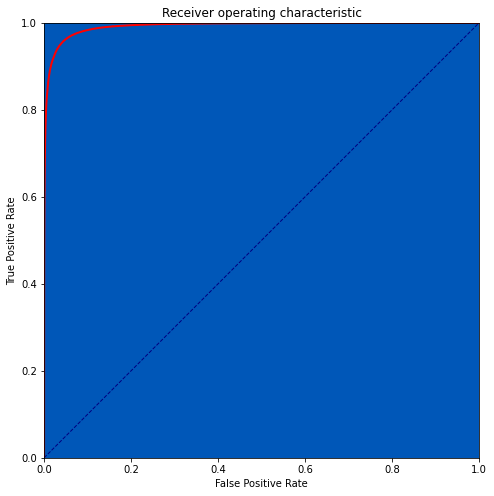

In [4]:
# Plot the roc curve for the last fold
def plot_roc_curve(y_va, y_va_pred):
    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_va, y_va_pred)
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.gca().set_aspect('equal')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.show()

plot_roc_curve(y_va, y_va_pred)

Second, we plot a histogram of the out-of-fold predictions. Many predictions are near 0.0 or near 1.0; this means that in many cases the classifier's predictions have high confidence:

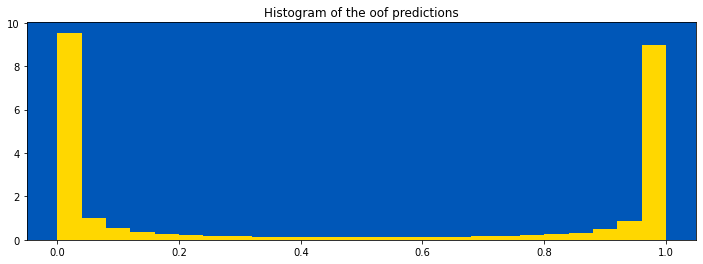

In [5]:
plt.figure(figsize=(12, 4))
plt.hist(y_va_pred, bins=25, density=True)
plt.title('Histogram of the oof predictions')
plt.show()


Finally, we plot the calibration curve. The curve here is almost a straight line, which means that the predicted probabilities are almost exact: 

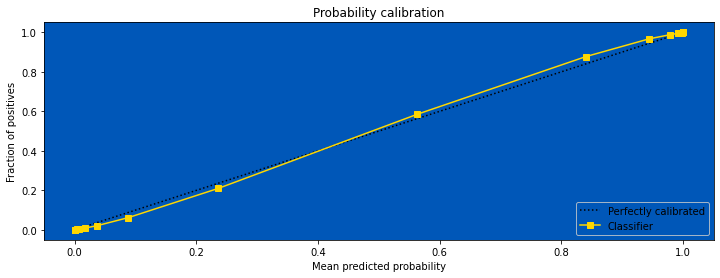

In [6]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=20, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

# Submission

For the submission, we re-train the model on several different seeds and then submit the mean of the ranks.

In [7]:
# Create submission
print(f"{len(features)} features")

pred_list = []
for seed in range(10):
    X_tr = train[features]
    y_tr = train.target

    model = my_booster(random_state=seed)
    model.fit(X_tr.values, y_tr)
    pred_list.append(scipy.stats.rankdata(model.predict_proba(test[features].values)[:,1]))
    print(f"{seed:2}", pred_list[-1])
print()
submission = test[['id']].copy()
submission['target'] = np.array(pred_list).mean(axis=0)
submission.to_csv('submission.csv', index=False)
submission

51 features
 0 [637176. 564970.  10693. ... 296501. 156926.   6761.]
 1 [649343. 562259.  13132. ... 285031. 101801.   9157.]
 2 [651711. 576428.  11055. ... 314110. 125830.   5418.]
 3 [644057. 563981.  10808. ... 282687. 166144.   5150.]
 4 [639576. 566089.  11429. ... 306597. 145885.   8445.]
 5 [631641. 562837.  13773. ... 314429. 145207.   6903.]
 6 [652760. 565150.  13656. ... 299261. 131294.   8387.]
 7 [642068. 579162.  12501. ... 301960. 108791.   5688.]
 8 [654932. 582259.  14700. ... 312262. 112512.   8931.]
 9 [635868. 558400.  10604. ... 332426. 134433.   6730.]



,id,target
0,900000,643913.2
1,900001,568153.5
2,900002,12235.1
3,900003,170205.8
4,900004,592611.3
...,...,...
699995,1599995,370115.7
699996,1599996,603497.4
699997,1599997,304526.4
699998,1599998,132882.3


# What next?

Now it's your turn! Try to improve this model by
- Engineering more features
- Tuning hyperparameters
- Replacing LightGBM by XGBoost, HistGradientBoostingClassifier or CatBoost 